In [ ]:
  from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2>Importing libraries</h2>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import time
seed=47

In [ ]:
invoice_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zindi/data/invoice_test.csv',low_memory=False,)
invoice_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zindi/data/invoice_train.csv',low_memory=False)
client_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zindi/data/client_test.csv',low_memory=False)
client_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zindi/data/client_train.csv',low_memory=False)
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zindi/data/SampleSubmission.csv',low_memory=False)

In [ ]:
sample_submission.head() #Fake!!  submit the class of client

In [ ]:
invoice_test['counter_statue'] = invoice_test['counter_statue'].astype('int64') #It's initialy an object

<h2>Basic EDA</h2>

We won't show full EDA, just want to attract your attention to tips which help us to reach good score.

In next two cells you will find value counts according each column in train and test set. This information we'll use in feature engeneering  

In [ ]:
ds = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=ds.index, height=ds.values, tick_label =[0,1])
plt.title('target distribution')
plt.show()

In [ ]:
for col in ['disrict','region','client_catg']:
    ds = client_train.groupby([col])['client_id'].count()
    plt.bar(x=ds.index, height=ds.values)
    plt.title(col+' distribution')
    plt.show()

In [ ]:
print('Number of missing rows in invoice_train:',invoice_train.isna().sum().sum())
print('Number of missing rows in invoice_test:',invoice_test.isna().sum().sum(),'\n')
print('Number of missing rows in client_train:',client_train.isna().sum().sum())
print('Number of missing rows in client_test:',client_test.isna().sum().sum())

In [ ]:
print('Number of unique values in invoice_train:')
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

Clear counter_statue  : it's Object on train set and int on test set

<h2>Feature engeneering</h2>

In this part we want to explain the most powerful decision in our notebook - feature creation

In [ ]:
def feature_change(cl, inv):

    cl['client_catg'] = cl['client_catg'].astype('category')
    cl['disrict'] = cl['disrict'].astype('category')
    cl['region'] = cl['region'].astype('category')
    cl['region_group'] = cl['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200)
    cl['creation_date'] = pd.to_datetime(cl['creation_date'])
    
    cl['coop_time'] = (2019 - cl['creation_date'].dt.year)*12 - cl['creation_date'].dt.month

    inv['counter_type'] = inv['counter_type'].map({"ELEC":1,"GAZ":0})
    inv['counter_statue'] = inv['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'769':5,'A':0,'618':5,'269375':5,'46':5,'420':5})
    
    inv['invoice_date'] = pd.to_datetime(inv['invoice_date'], dayfirst=True)
    inv['invoice_month'] = inv['invoice_date'].dt.month
    inv['invoice_year'] = inv['invoice_date'].dt.year
    inv['is_weekday'] = ((pd.DatetimeIndex(inv.invoice_date).dayofweek) // 5 == 1).astype(float)
    inv['delta_index'] = inv['new_index'] - inv['old_index']
    
    return cl, inv

* 'client_catg', 'district' and 'region' were assigned as categories to use them as categorical features in lgbm (as for me, lgbm for default threats with cat features slightly better than other encoders such as catboost/target encoder)
* 'region_group' created simply by dividing 'region' in 3 groups (we purposed that regions weren't randomly decoded)
* 'coop_time' - amount of time since account creation in months
* 'counter_type' was binary encoded 
* 'counter_statue' cleaned from mislabeled values
* extracted month, year from 'invoice_date', also added binary feature - 'is_weekday'
* not sure about any logical sense in 'delta_index', but it improved score

In [ ]:
client_train1, invoice_train1 = feature_change(client_train, invoice_train)
client_test1, invoice_test1 = feature_change(client_test, invoice_test)

In [ ]:
def agg_feature(invoice, client_df, agg_stat):
    
    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['mean','std','min','max'])
    
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')
    
    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')
    
    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')
    
    full_df['invoice_per_cooperation'] = full_df['transactions_count'] / full_df['coop_time']
    
    return full_df

* created some aggregation features (min/max/mean/std) over continious columns per every client
* added 'delta_time' - amount of time between invoices for each user
* created 'invoice_per_cooperation' - number of transactions per some amount of time

In [ ]:
agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'invoice_month',
 'invoice_year',
 'delta_index'
]

train_df1 = agg_feature(invoice_train1, client_train1, agg_stat_columns)
test_df1 = agg_feature(invoice_test1, client_test1, agg_stat_columns)

In [ ]:
#Replace all NaN values by the most frequent value of the corresponding feature
train_df1 = train_df1.apply(lambda x:x.fillna(x.value_counts().index[0]))
test_df1 = test_df1.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [ ]:
train_df1_na = test_df1[test_df1.isnull().any(axis=1)] #has it NaN values in the dataset??

In [ ]:
train_df1_na.head()

,disrict,client_id,client_catg,region,creation_date,region_group,coop_time,is_weekday_mean,transactions_count,tarif_type_mean,tarif_type_std,tarif_type_min,tarif_type_max,counter_number_mean,counter_number_std,counter_number_min,counter_number_max,counter_statue_mean,counter_statue_std,counter_statue_min,counter_statue_max,counter_code_mean,counter_code_std,counter_code_min,counter_code_max,reading_remarque_mean,reading_remarque_std,reading_remarque_min,reading_remarque_max,consommation_level_1_mean,consommation_level_1_std,consommation_level_1_min,consommation_level_1_max,consommation_level_2_mean,consommation_level_2_std,consommation_level_2_min,consommation_level_2_max,consommation_level_3_mean,consommation_level_3_std,consommation_level_3_min,consommation_level_3_max,consommation_level_4_mean,consommation_level_4_std,consommation_level_4_min,consommation_level_4_max,old_index_mean,old_index_std,old_index_min,old_index_max,new_index_mean,new_index_std,new_index_min,new_index_max,months_number_mean,months_number_std,months_number_min,months_number_max,counter_type_mean,counter_type_std,counter_type_min,counter_type_max,invoice_month_mean,invoice_month_std,invoice_month_min,invoice_month_max,invoice_year_mean,invoice_year_std,invoice_year_min,invoice_year_max,delta_index_mean,delta_index_std,delta_index_min,delta_index_max,delta_time_mean,delta_time_std,delta_time_min,delta_time_max,invoice_per_cooperation


Also we created statistical 'max_mean' and 'range' features which noticeably improved score

In [ ]:
def new_features(df):
    for col in agg_stat_columns:
        df[col+'_range'] = df[col+'_max'] - df[col+'_min']
        df[col+'_max_mean'] = df[col+'_max']/df[col+'_mean']
    return df

In [ ]:
train_df2 = new_features(train_df1)
test_df2 = new_features(test_df1)

In [ ]:
test_df2 = test_df2.apply(lambda x:x.fillna(x.value_counts().index[0]))
train_df2 = train_df2.apply(lambda x:x.fillna(x.value_counts().index[0]))

Now let's review how many features did we create:

In [ ]:
print('Initial number of columns: ', len(client_train.columns)+len(invoice_train.columns))
print('Number of columns now: ', len(train_df2.columns))

Initial number of columns:  29
Number of columns now:  79


In [ ]:
def drop(df):

    col_drop = ['client_id', 'creation_date']
    for col in col_drop:
        df.drop([col], axis=1, inplace=True)
    return df

* we dropped some unnessesary columns in next few cells
* 'drop_col' array was made after using feature selection

In [ ]:
train_df = drop(train_df2)
test_df = drop(test_df2)

In [ ]:
#Has it a NaN in the dataset?
train_df_na = train_df[train_df.isnull().any(axis=1)]
train_df_na.head()

,disrict,client_catg,region,target,region_group,coop_time,is_weekday_mean,transactions_count,tarif_type_mean,tarif_type_std,tarif_type_min,tarif_type_max,counter_number_mean,counter_number_std,counter_number_min,counter_number_max,counter_statue_mean,counter_statue_std,counter_statue_min,counter_statue_max,counter_code_mean,counter_code_std,counter_code_min,counter_code_max,reading_remarque_mean,reading_remarque_std,reading_remarque_min,reading_remarque_max,consommation_level_1_mean,consommation_level_1_std,consommation_level_1_min,consommation_level_1_max,consommation_level_2_mean,consommation_level_2_std,consommation_level_2_min,consommation_level_2_max,consommation_level_3_mean,consommation_level_3_std,consommation_level_3_min,consommation_level_3_max,...,delta_index_std,delta_index_min,delta_index_max,delta_time_mean,delta_time_std,delta_time_min,delta_time_max,invoice_per_cooperation,tarif_type_range,tarif_type_max_mean,counter_number_range,counter_number_max_mean,counter_statue_range,counter_statue_max_mean,counter_code_range,counter_code_max_mean,reading_remarque_range,reading_remarque_max_mean,consommation_level_1_range,consommation_level_1_max_mean,consommation_level_2_range,consommation_level_2_max_mean,consommation_level_3_range,consommation_level_3_max_mean,consommation_level_4_range,consommation_level_4_max_mean,old_index_range,old_index_max_mean,new_index_range,new_index_max_mean,months_number_range,months_number_max_mean,counter_type_range,counter_type_max_mean,invoice_month_range,invoice_month_max_mean,invoice_year_range,invoice_year_max_mean,delta_index_range,delta_index_max_mean


In [ ]:
y = train_df['target']
X = train_df.drop('target',axis=1)

feature_name = X.columns.tolist()

In [ ]:
y = np.where(y==0.0,0,1)

In [ ]:
drop_col=['reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max','counter_type_range',
          'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean']
'''
drop_col=['reading_remarque_max','counter_statue_min',
          'tarif_type_max', 'delta_index_min']
'''

test_df = test_df.drop(drop_col, axis=1)
X = X.drop(drop_col, axis=1)

In [ ]:
(test_df.shape,X.shape)

((58069, 100), (135493, 100))

In [ ]:
X.isnull().values.sum()

0

<h2>Modelling</h2>

* we used [optuna](https://optuna.org/) for hyperparameters tuning
* it was performed with respect to StratifiedKFold cross validation on 5 folds
* you can check parameters for tuning and their final values in cells below

In [ ]:
!pip install optuna

In [ ]:
from optuna import Trial
import gc
import optuna
from sklearn.model_selection import train_test_split
import lightgbm as lgb

category_cols = ['disrict', 'client_catg', 'region']

def objective(trial:Trial):
    
    gc.collect()
    models=[]
    validScore=0
   
    model,log = fitLGBM(trial,X,y)
    
    models.append(model)
    gc.collect()
    validScore+=log
    validScore/=len(models)
    
    return validScore

In [ ]:
def fitLGBM(trial,X, y):
    best_threshold = 0.5
    best_score = 0
    params={
      'n_estimators':trial.suggest_int('n_estimators', 0, 1000), 
      'num_leaves':trial.suggest_int('num_leaves', 2, 512),
      'max_depth':trial.suggest_int('max_depth', 2, 128),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.15),
      'min_split_gain': trial.suggest_loguniform('min_split_gain', 0.001, 0.1),
      'feature_fraction':trial.suggest_uniform('feature_fraction',0.1, 1.0),
      'bagging_freq':trial.suggest_int('bagging_freq',0.1,10),
      'verbosity': -1,
      'random_state':seed
            }
    stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = LGBMClassifier(**params)
    
    res=[]
    for i, (tdx, vdx) in enumerate(stkfold.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        preds = model.predict_proba(X_valid)
        precision, recall, thresholds = precision_recall_curve(y_valid, preds[:,1])
        fscore = (2 * precision * recall) / (precision + recall)
        index = np.argmax(fscore)
        thresholdOpt = round(thresholds[index], ndigits = 4)
        fscoreOpt = round(fscore[index], ndigits = 4)
        if(fscoreOpt>best_score):
          best_score = fscoreOpt
          best_threshold = thresholdOpt
        res.append(fscoreOpt)
    
    err = np.mean(res)
    
    return model, err , best_score, best_threshold

In [ ]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=50)
study.best_params

In [ ]:
#Best params with 50 trials. May be more trials can get better result. 
#{'n_estimators': 902, 'num_leaves': 125, 'max_depth': 106, 'learning_rate': 0.09519775096900134, 'min_split_gain': 0.0019903163135690494, 'feature_fraction': 0.7159531407543521, 'bagging_freq': 7}. Best is trial 33 with value: 0.3113639033806024.

In [ ]:
def optimizeThreshold(preds,test):
  best_threshold = 0.5
  best_score = 0.2
  for i in range(1 , 10):
    pred_tmp = np.where(preds >= (i/10) , 1 ,0)
    cost = f1_score(pred_tmp,test)
    if(cost > best_score ):
      best_score = cost
      best_threshold = i/10
  return best_threshold, best_score  

In [ ]:
model = LGBMClassifier(random_state=seed, n_estimators=902,num_leaves=125, max_depth=106,
                       learning_rate=0.09519775096900134, min_split_gain=0.0019903163135690494, 
                       feature_fraction=0.7159531407543521, bagging_freq=7)

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def calc(X, y, model, cv):
    best_threshold = 0.5
    best_score = 0
    local_probs=pd.DataFrame()
    probs = pd.DataFrame()

    for i, (tdx, vdx) in enumerate(cv.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        
        preds = model.predict_proba(X_valid)
        oof_predict = model.predict_proba(test_df)
        local_probs['fold_%i'%i] = oof_predict[:,1]
        precision, recall, thresholds = precision_recall_curve(y_valid, preds[:,1])
        fscore = (2 * precision * recall) / (precision + recall)
        index = np.argmax(fscore)
        thresholdOpt = round(thresholds[index], ndigits = 4)
        fscoreOpt = round(fscore[index], ndigits = 4)
        if(fscoreOpt>best_score):
          best_score = fscoreOpt
          best_threshold = thresholdOpt
          probs['best_target'] =  oof_predict[:,1]
    print('F1 Score:', best_score)    
    local_probs['res'] = local_probs.mean(axis=1)
    probs['target'] = local_probs['res']
    
    return probs, best_threshold, best_score,

<h2>Prediction and submission</h2>

In the next few cells you can see our local cross validation which almost match  LB score

In [ ]:
%%time
probs , threshold , score = calc(X, y, model, stkfold)


F1 Score: 0.4461
CPU times: user 1min 58s, sys: 1.08 s, total: 1min 59s
Wall time: 1min 2s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning:

invalid value encountered in true_divide



In [ ]:
score

0.4461

In [ ]:
threshold

0.2026

In [ ]:
probs

,best_target,target
0,0.031899,0.024195
1,0.094155,0.112364
2,0.012552,0.015091
3,0.002532,0.004478
4,0.052800,0.040321
...,...,...
58064,0.000772,0.001658
58065,0.015775,0.016441
58066,0.565627,0.601604
58067,0.002409,0.004253


In [ ]:
submission = pd.DataFrame({
        "client_id": sample_submission["client_id"],
        "target":np.where(probs['target'] >= threshold, 1 ,0)
    })
submission.to_csv('submission.csv', index=False)

In [ ]:
test_submit = pd.read_csv('submission.csv')
test_submit.head()


,client_id,target
0,test_Client_0,0
1,test_Client_1,0
2,test_Client_10,0
3,test_Client_100,0
4,test_Client_1000,0


In [ ]:
test_submit.shape

(58069, 2)

In [ ]:
#Best soumission : soumission_23.csv , F1 score = 0.4397

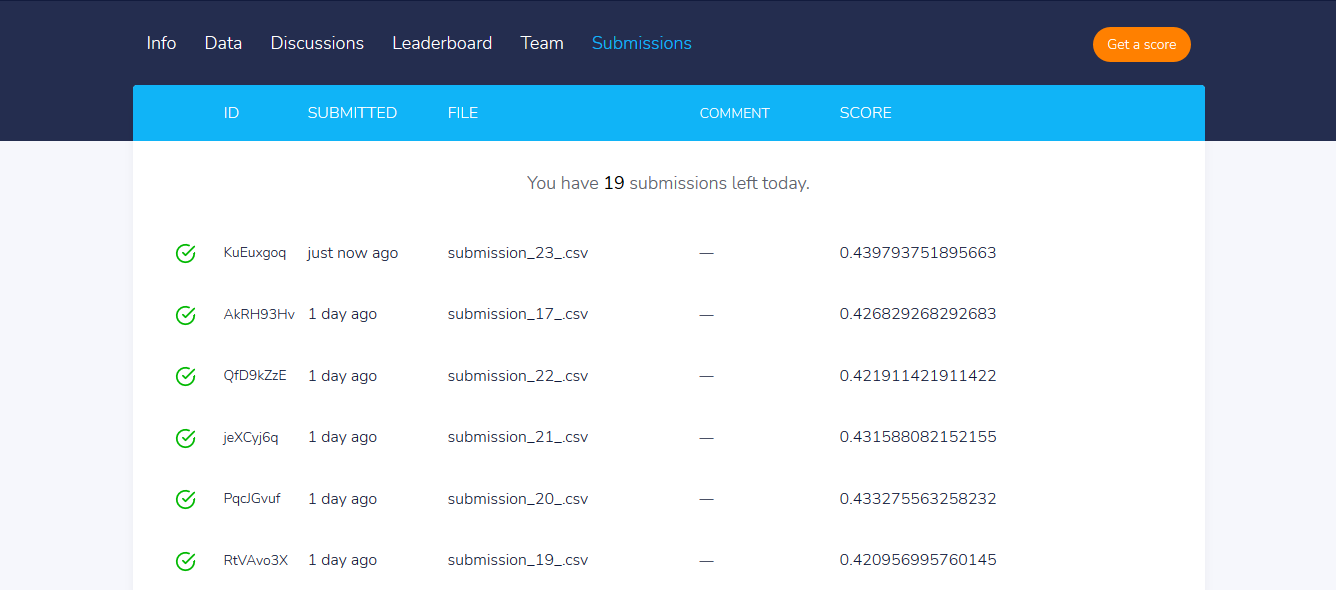

In [ ]:
#2nd Place

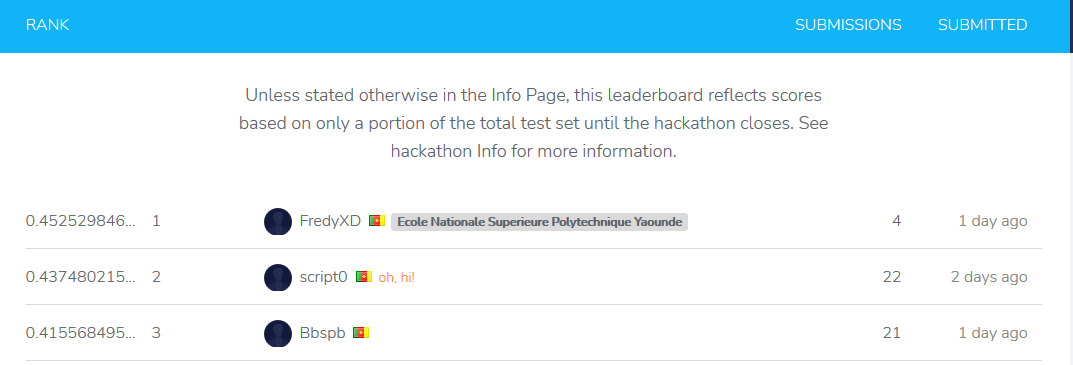